# Regelung von CartPole Env

## CartPole Environment

Es handelt sich im Wesentlichen um ein Problem mit dem umgekehrten Pendel, bei dem es unser Ziel ist, den Kartuschen in der Mitte im Gleichgewicht zu halten - das Pendel schwingt, kann aber durch geeignete horizontale Kräfte an Ort und Stelle gehalten werden. Der Cartpole-Agent kann nur zwei mögliche Aktionen ausführen: nach links oder nach rechts. Die Zustände in dieser Umgebung umfassen die Position des Drehpunkts, seine Geschwindigkeit, seinen Winkel und seine Winkelgeschwindigkeit; Ohne auf die Physik einzugehen, ist hier zu schließen, dass unser Zustandsraum kontinuierliche Werte und vier Dimensionen hat.

Wir bekommen eine Belohnung, solange unser Cartpole nicht herunterfällt. Sobald dies passiert ist, ist die Spielepisode vorbei. Um zu gewinnen, müssen wir eine Verhaltensrichtlinie finden, die es unserem Pole-Agenten ermöglicht, aufrecht zu bleiben - mit anderen Worten, eine konstant hohe Belohnung zu erhalten (das Maximum beträgt 500 in Cartpole Version 1, die wir verwenden

state (observation from cart-pole system):
+ Type: Box(4) - cart_position, cart_velocity, pole_angle, pole_tip_velocity
+ cart_position: -2.4 ~ 2.4
+ cart_velocity: -inf ~ inf
+ pole_angle:    -41.8° ~ 41.8°
+ tip_velocity:  -inf ~ inf

actions:
+ Type: Discrete(2)
+ 0: push cart to left
+ 1: push cart to right

## Environment und zufällige Aktionen

In [1]:
import numpy as np
import gym

env = gym.make("CartPole-v1")
statespace_size = env.observation_space.shape[0]
actionspace_size = env.action_space.n
rewards = 0
print("Aktionsraum {}".format(env.action_space))
print("Zustandsraum {}".format(env.observation_space))

state = env.reset()
done = False
        
while not done:
    action = env.action_space.sample()
    env.render(mode="rgb_array")
    next_state, reward, done, info = env.step(action)
    state = next_state
    rewards += reward

print(rewards)
env.close()

Aktionsraum Discrete(2)
Zustandsraum Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
17.0


# Deep Q-Network Regler

In [33]:
import numpy as np
import gym
import time
import random
from collections import deque
from matplotlib import animation
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.activations import relu, linear

## Utils Funktionen

Funktion zum plotten der Cart Eigenschaften (Position, Geschwindigkeit, Winkel und Winkelgeschwindigkeit)

In [36]:
def plotEnv(cartPosition, cartVelocity, angle, angleVelocity):
    fig, axs = plt.subplots(2, 2)

    axs[0, 0].plot(cartPosition, "b-")
    axs[0, 0].set_ylabel('Cart Position')

    axs[0, 1].plot(cartVelocity, "r-")
    axs[0, 1].set_ylabel('Cart Velocity')

    axs[1, 0].plot(angle, "k-")
    axs[1, 0].set_ylabel('Angle')

    axs[1, 1].plot(angleVelocity, "g-")
    axs[1, 1].set_ylabel('Angle Velocity')

    plt.savefig("Cart.png")                       

## Definition von Parameter

In [62]:
start_time = time.time()
env = gym.make("CartPole-v1")
statespace_size = env.observation_space.shape[0]
actionspace_size = env.action_space.n
print("Aktionsraum {}".format(env.action_space))
print("Zustandsraum {}".format(env.observation_space))
memory = deque(maxlen = 500000)
alpha = 0.001
gamma = 0.99
batch_size = 32
num_episodes = 100
epsilon = 1.0
min_epsilon = 0.1
max_epsilon = 1.0
decay_epsilon = 0.005
rewardList = []
ave_rewards = []

Aktionsraum Discrete(2)
Zustandsraum Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


## Training des DQN Reglers

In [63]:
model = Sequential()
model.add(Dense(24, input_dim=statespace_size, activation="relu"))
model.add(Dense(24, activation="relu"))
model.add(Dense(actionspace_size, activation="linear"))
model.compile(loss="mse", optimizer=Adam(lr=alpha))
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_16 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
None


### Training DQN Algorithmus für den Regler

Episode: 0, Reward: 19.0
Episode: 1, Reward: 25.0
Episode: 2, Reward: 33.0
Episode: 3, Reward: 14.0
Episode: 4, Reward: 15.0
Episode: 5, Reward: 18.0
Episode: 6, Reward: 18.0
Episode: 7, Reward: 10.0
Episode: 8, Reward: 20.0
Episode: 9, Reward: 17.0
Episode: 10, Reward: 27.0
Episode: 11, Reward: 15.0
Episode: 12, Reward: 24.0
Episode: 13, Reward: 10.0
Episode: 14, Reward: 20.0
Episode: 15, Reward: 14.0
Episode: 16, Reward: 11.0
Episode: 17, Reward: 31.0
Episode: 18, Reward: 16.0
Episode: 19, Reward: 13.0
Episode: 20, Reward: 10.0
Episode: 21, Reward: 20.0
Episode: 22, Reward: 58.0
Episode: 23, Reward: 16.0
Episode: 24, Reward: 14.0
Episode: 25, Reward: 10.0
Episode: 26, Reward: 18.0
Episode: 27, Reward: 35.0
Episode: 28, Reward: 18.0
Episode: 29, Reward: 17.0
Episode: 30, Reward: 23.0
Episode: 31, Reward: 38.0
Episode: 32, Reward: 12.0
Episode: 33, Reward: 48.0
Episode: 34, Reward: 31.0
Episode: 35, Reward: 14.0
Episode: 36, Reward: 25.0
Episode: 37, Reward: 13.0
Episode: 38, Reward: 1

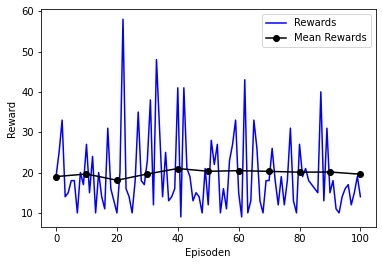

In [64]:
for eps in range(num_episodes+1):       
    state = env.reset()
    state = np.reshape(state, [1, statespace_size])
    done = False
    total_rewards = 0

    while not done:
        if random.uniform(0, 1) > epsilon:
            QValue = model.predict(state)
            action = np.argmax(QValue[0])
        else:
            action = random.randrange(actionspace_size)
        
        nextState, reward, done, info = env.step(action)
        
        nextState = np.reshape(nextState, [1, statespace_size])
        memory.append((state, action, reward, nextState, done))
        state = nextState
        total_rewards += reward

        if len(memory) > batch_size:  
            randomSample = random.sample(memory, batch_size)
            for stateSample, actionSample, rewardSample, nextStateSample, doneSample in randomSample:
                QUpdate = rewardSample + gamma * (np.amax(model.predict(nextStateSample)[0])) * (1 - doneSample)
                QValue = model.predict(stateSample)
                QValue[0][actionSample] = QUpdate
                
                model.fit(stateSample, QValue, verbose=0) 

    if epsilon > min_epsilon:
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_epsilon*eps)

    print("Episode: {}, Reward: {}".format(eps, total_rewards))
    rewardList.append(total_rewards)

    if eps % 10 == 0:
        average = np.mean(rewardList)
        ave_rewards.append(average)

        if average > 250:
            model.save('Episode_' + str(eps) + '_weight.h5')
            print('Aufgabe gelöst!')
            break
            
    if eps % 50 == 0:
        model.save('Episode_' + str(eps) + '_weight.h5')
        
print("--- %s hours ---" % str((time.time() - start_time)/3600))
plotRewards(rewardList, ave_rewards, 10)
env.close()

# DQN Regler anwenden

In [ ]:
env = gym.make("CartPole-v1")
print("Aktionsraum {}".format(env.action_space))
print("Zustandsraum {}".format(env.observation_space))
episodes = ['0', '50', '100', '150', '200', '250', '300', '350', '400', '450', '500']

In [ ]:
for eps in episodes:
    angle = []
    angle_velo = []
    cart_pos = []
    cart_velo = []

    #Initialisierung des neuronalen Netzes
    model = Sequential()
    model.add(Dense(24, input_dim=statespace_size, activation="relu"))
    model.add(Dense(24, activation="relu"))
    model.add(Dense(actionspace_size, activation="linear"))
    model.compile(loss="mse", optimizer=Adam(lr=alpha))
    print(model.summary())
    model.load_weights('Episode_' + str(eps) + '_weight.h5')

    state = env.reset()
    frames = []
    state = np.reshape(state, [1, env.observation_space])
    done = False
            
    while not done:
        frames.append(env.render(mode="rgb_array"))

        QValue = model.predict(state)
        action = np.argmax(QValue[0])
        next_state, reward, done, info = env.step(action)
        
        cart_pos.append(next_state[0])
        cart_velo.append(next_state[1])
        angle.append(next_state[2])
        angle_velo.append(next_state[3])
            
        next_state = np.reshape(next_state, [1, env.observation_space])
        state = next_state
            
    save_frames_as_gif(frames, filename='Episode_' + str(eps) + "_DQNCartPole.gif")
    plotEnv(cart_pos, cart_velo, angle, angle_velo)

# PID Regler

In [1]:
from ..Examples/DRL-Controller import PIDController

## Utils Funktionen

Funktion zum schreiben einer gif Datei

Funktion zum plotten der Cart Eigenschaften (Position, Geschwindigkeit, Winkel und Winkelgeschwindigkeit)

## Definition der Parameter

In [4]:
class CartPoleController(PIDController):
    def __init__(self):
        super.__init__("CartPole-v1")
        self.cart_pos = []
        self.cart_velo = []
        self.angle = []
        self.angle_velo = []
        self.initstate = self.env.reset()
        
    def getAction(self, val):
        action = 0 
        if val >= 0:
            action = 0
        else:
            action = 1

        return action

    def plot(self):
        save_frames_as_gif(self.frames, filename="PIDController.gif")
        plotEnv(self.cart_pos, self.cart_velo, self.angle, self.angle_velo)
        #plotController(ptermlist, itermlist, dtermlist, outputlist)

    def close(self):
        env.close()

## Regler

Aktionsraum Discrete(2)
Zustandsraum Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


<ipython-input-4-4b5eedeb509b>:45: RuntimeWarning: divide by zero encountered in double_scalars
  self.dterm = (self.prev_error - error)/dt
MovieWriter imagemagick unavailable; using Pillow instead.


NameError: name 'cart_pos' is not defined

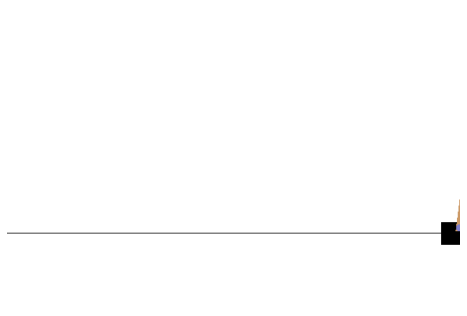

In [5]:
Controller = CartPoleController()
Controller.control()

MovieWriter imagemagick unavailable; using Pillow instead.


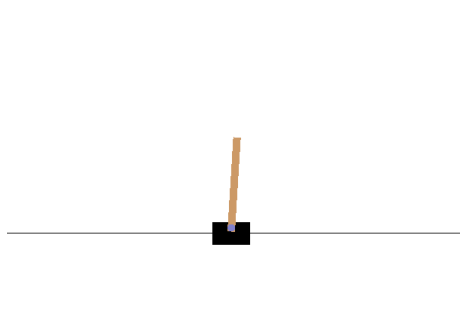

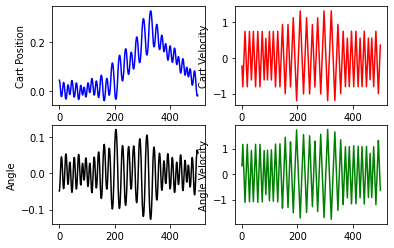

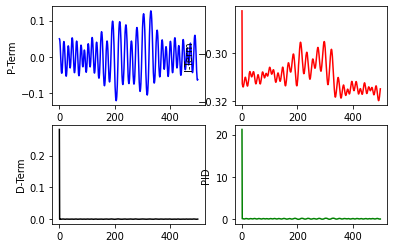